This task intends to measure your deep learning basic skills. We will provide you a dataset containing 131 different fruits. Download it from this [link](https:///www.kaggle.com/moltean/fruits), download it and upload it to your copy of this file

You have to implement a Convolutional Neural Network to classify the input fruit image. For this task, you must follow the following rules:

- Use a ResNet50 as your CNN backbone.
- The model output must be a probability score for all the classes.
- You can implement the model in any Deep Learning framework that you are used to use.
- Make sure you write your code following the best practices.
- Make sure you document all the steps you took to solve the problem.


In [1]:
# Import all needed libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

#Auxiliary libraries
from os import listdir, path
import os

#Configure memory usage to the GPU device
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#Declaring and defining the constants

###----- Here the constants related to datasets and dataframes are being defined ----###
BASE_FOLDER = 'data'
TRAIN_FOLDER = 'data/Training' 
TEST_FOLDER = 'data/Test'
TRAIN_DF = 'train_df.csv'
TEST_DF = 'test_df.csv'
COLUMNS = {
    'LABEL':'label',
    'FILE':'file'
}

###----- Here we define the params and hyperparams to train the model -----###
INPUT_SHAPE = (100,100,3)
IMG_SIZE = (100,100)
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42
CHECKPOINT_PATH = 'model/epoch-{epoch}_valloss-{val_loss:.2f}.hdf5'

In [3]:
def generate_dataframe(data_folder, columns = COLUMNS):
    """Generate a dataframe containing the file path and the respective label
    
    Params:
        data_folder:str - folder to witch the dataframe will be created (train or test).
        
        columns:dict - A dictionay to name the columns
        
    Returns:
        dataframe:pd.DataFrame - The dataframe containing the files and labels.
    """
    labels = listdir(data_folder)
    
    dataframe = pd.DataFrame()
    
    for lbl in labels:
        data = {
            columns['FILE'] : [path.join(lbl,file) for file in listdir(path.join(data_folder,lbl))],
            columns['LABEL']: lbl
        }
        df = pd.DataFrame(data)
        
        dataframe = dataframe.append(df)
    
    return dataframe.sample(frac=1).reset_index(drop=True)

def load_dataframe(df_path):
    """Loads the dataframe from the specified path
    
    Params:
        df_path:str - Path to the dataframe to be loaded.
        
    Returns:
        dataframe:(pd.DataFrame|None) - If the file exists, returns the dataframe, otherwise returns None.
    """
    if path.isfile(df_path):
        return pd.read_csv(df_path)
    else:
        return None


In [4]:
#Load the dataframe
#Try to load the train dataframe
train_df = load_dataframe(path.join(BASE_FOLDER, TRAIN_DF))

#Check if loading was succeful, if not, generates and saves the dataframe.
if train_df is None:
    train_df = generate_dataframe(TRAIN_FOLDER)
    train_df.to_csv(path.join(BASE_FOLDER, TRAIN_DF),index=False)
    
#Try to load the test dataframe
test_df = load_dataframe(path.join(BASE_FOLDER, TEST_DF))

#Check if loading was succeful, if not, generates and saves the dataframe.
if test_df is None:
    test_df = generate_dataframe(TEST_FOLDER)
    test_df.to_csv(path.join(BASE_FOLDER, TEST_DF),index=False)

In [5]:
CLASSES = pd.unique(train_df['label']) #generate a list of classes
QTT_CLASSES = CLASSES.shape[0] #counts the numbers of classes

In [6]:
#Creates the image data generator using the ResNet50 preprocess and make the pixel values be between 0 and 1
train_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale = 1./255,
    validation_split = VAL_SIZE)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale = 1./255)

In [7]:
#To optimize the RAM usage, we use the flow method from generator continuously provide images

train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = TRAIN_FOLDER,
    x_col = COLUMNS['FILE'],
    y_col = COLUMNS['LABEL'],
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED,
    subset = 'training',
    rotation_range = 30,
    zoom_range = 0.10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest")

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = TRAIN_FOLDER,
    x_col = COLUMNS['FILE'],
    y_col = COLUMNS['LABEL'],
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED,
    subset = 'validation',
    rotation_range = 30,
    zoom_range = 0.10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest")

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory = TEST_FOLDER,
    x_col = COLUMNS['FILE'],
    y_col = COLUMNS['LABEL'],
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle=False)

Found 54154 validated image filenames belonging to 131 classes.
Found 13538 validated image filenames belonging to 131 classes.
Found 22688 validated image filenames belonging to 131 classes.


In [8]:
#Load the Resnet 50 with its tops layers
resnet50 = ResNet50(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

In [9]:
#The ResNet model it is without the top layers so we customize to fits our needs
inputs = resnet50.input

layer = Dense(128, activation='relu')(resnet50.output)
layer = Dense(128, activation='relu')(layer)

outputs = Dense(QTT_CLASSES, activation='softmax')(layer)

model = Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# model.summary()

In [10]:
#Defines the callbacks to use during training

#Reduces learning rate on plateou
reduceLROnplateou = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.001)

#stops training when the validation loss doesn't improve
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights = True)

#Saves the model checkpoint each time the validation loss improves
checkPoint = ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    monitor='val_loss',
    save_best_only=True)

callbacks = [reduceLROnplateou, earlyStopping, checkPoint]


In [11]:
#Trains the model and saves the training history
history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = EPOCHS,
    steps_per_epoch = len(train_images),
    validation_steps = len(val_images),
    callbacks = callbacks,
    workers = 6
)

Epoch 1/30
1693/1693 [==============================] - 369s 218ms/step - loss: 0.4102 - accuracy: 0.8918 - val_loss: 0.1499 - val_accuracy: 0.9535 - lr: 0.0010
Epoch 2/30
1693/1693 [==============================] - 326s 192ms/step - loss: 0.0686 - accuracy: 0.9811 - val_loss: 0.5323 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/30
1693/1693 [==============================] - 325s 192ms/step - loss: 0.0513 - accuracy: 0.9857 - val_loss: 0.0330 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 4/30
1693/1693 [==============================] - 327s 193ms/step - loss: 0.0457 - accuracy: 0.9881 - val_loss: 0.0065 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 5/30
1693/1693 [==============================] - 330s 195ms/step - loss: 0.0335 - accuracy: 0.9918 - val_loss: 0.0287 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/30
1693/1693 [==============================] - 330s 195ms/step - loss: 0.0296 - accuracy: 0.9925 - val_loss: 0.0528 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 7/30
1693/1693 [============

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

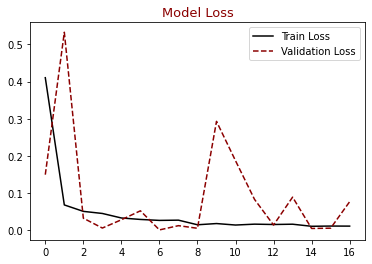

In [15]:
plt.figure()
plt.plot(history.history["loss"],label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"],label = "Validation Loss", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Loss", color = "darkred", size = 13)
plt.legend()
plt.show()

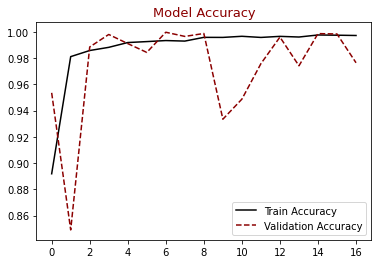

In [16]:
plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()